## Setup

In [1]:
import pandas as pd

from tqdm.notebook import tqdm

import gurobipy as gp
from gurobipy import GRB

from gurobi_models import get_installation

from kcmc_instance import KCMC_Instance

# kcmc_instance, kcmc_requirements = pd.read_csv('/data/small_instances.csv', sep='|').iloc[0]
df = pd.read_csv('/data/instances.csv', sep='|', header=None)
df = df[df[0].str.contains('229699545')]
kcmc_instance, kcmc_requirements = df.iloc[0]
kcmc_requirements = kcmc_requirements.strip()
kcmc_k, kcmc_m = map(int, [kcmc_requirements[2], kcmc_requirements[4]])
# kcmc_k, kcmc_m = 3, 2
kcmc_instance = KCMC_Instance(kcmc_instance, accept_loose_sensors=True)
kcmc_instance, (kcmc_k, kcmc_m)

(<KCMC;100 100 1;300 50 100;229699545;END 229699545 [0]>, (3, 2))

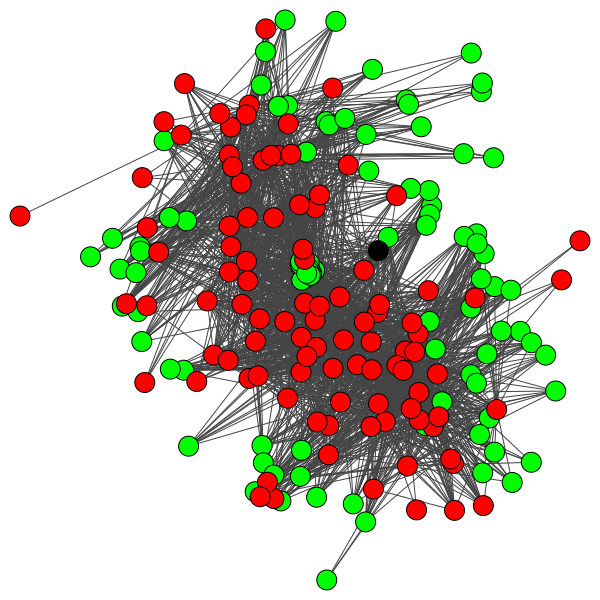

In [2]:
kcmc_instance.plot()

## Instance Constants

In [3]:
iC = kcmc_instance.inverse_coverage_graph
L = [str(m) for m in range(kcmc_m)]
P = kcmc_instance.pois
I = kcmc_instance.sensors
S = kcmc_instance.sinks
s = list(S)[0]  # HARD-CODED ASSUMPTION OF SINGLE-SINK!
A_c = kcmc_instance.poi_edges
A_s = kcmc_instance.sink_edges
A_g = kcmc_instance.sensor_edges
A = A_c + A_g + A_s

# MULTI-FLOW ILP

In [4]:
model = gp.Model('KCMC MULTI-FLOW')

# Metadata
model.setParam(GRB.Param.TimeLimit, 600.0)
model.setParam(GRB.Param.Threads, 1)

# Variables
X = model.addVars(I, L, vtype=GRB.BINARY, name="x")
Y = model.addVars(A, P, L,
                  #vtype=GRB.BINARY,
                  name='y')

# Objective Funcion
model.setObjective(X.sum('*', '*'), GRB.MINIMIZE)

[client] info  : Using libcurl/7.76.1 OpenSSL/1.1.1k
[client] info  : Default certificate path is /etc/ssl/certs/ca-certificates.crt
[client] info  : No HTTPS proxy
[client] info  : No HTTP proxy
[client] info  : Validate web license token dd03e583-3025-4694-b5fd-1e3e04179329 for container 04f0232a601d8106cfea372cdf033c23e7a7fbd9de4358413e902b86b9c8a2bb
Academic license - for non-commercial use only - registered to jose.fonseca@dcc.ufmg.br
[client] info  : Web license token valid
Using license file /opt/gurobi/gurobi.lic
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID
Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter Threads to 1
   Prev: 0  Min: 0  Max: 1024  Default: 0


## Constraints

### Disjunction
- An instalation spot with an installed sensor may belong to a single Steiner Tree, regardless of the POIs it serves.

In [5]:
disjunction = model.addConstrs(
    (X.sum(i, '*') <= 1
     for i in I),
    name="disjunction"
)

### Flow

- For any given POI $p \in P$ and (the) SINK $s \in S$
    - For any VERTICE $v \in P \bigcup I \bigcup S$
        - The sum of PARTICIPANT edges in the $l$-th Steiner Tree ($l \in L$) started in POI $p$ that LEAVE $v$, minus the sum of those that ARRIVE at $v$ must be equal to:
            - $1$ if $v=p$
            - $-1$ if $v=s$
            - 0 otherwise
- That is to say, the flow that leaves each vertex in each Steiner Tree is 1 if the vertex is a POI, -1 if it is a (the) sink and 0 otherwise

In [6]:
flow_p = model.addConstrs(
    ((  gp.quicksum(Y.select(p, '*', p, l))
      - gp.quicksum(Y.select('*', p, p, l))) == 1
     for p in P
     for l in L),
    name="flow_p"
)


flow_i = model.addConstrs(
    ((  gp.quicksum(Y.select(i, '*', p, l))
      - gp.quicksum(Y.select('*', i, p, l))) == 0
     for i in I
     for p in P
     for l in L),
    name="flow_i"
)


flow_s = model.addConstrs(
    ((  gp.quicksum(Y.select(s, '*', p, l))
      - gp.quicksum(Y.select('*', s, p, l))) == -1
     for p in P
     for l in L),
    name="flow_s"
)

### Projection
- Only relationship between Y and X
- For an edge (starting in a sensor) to participate in any Steiner Tree, its origin sensor must be installed in that tree

In [7]:
projection = model.addConstrs(
    (Y.sum(i, '*', p, l) <= X.sum(i, l)
     for i in I
     for p in P
     for l in L),
    name="projection"
)

### K-Coverage

- Every POI must be covered by at least K different installed sensors

In [8]:
k_coverage = model.addConstrs(
    (gp.quicksum(X.select(iC[p], '*')) >= kcmc_k
     for p in P),
    name="k_coverage"
)

## Runtime

- Execute the model optimization.
- Unfeasible conclusions means that the WSN instance is NOT certified for K and M!

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 1 threads
[client] info  : Validate web license token dd03e583-3025-4694-b5fd-1e3e04179329 for container 04f0232a601d8106cfea372cdf033c23e7a7fbd9de4358413e902b86b9c8a2bb
[client] error : Web license token expired
[client] info  : Validate web license token c6b3749f-3d87-4c57-af21-51f47c2de1e2 for container 04f0232a601d8106cfea372cdf033c23e7a7fbd9de4358413e902b86b9c8a2bb
Academic license - for non-commercial use only - registered to jose.fonseca@dcc.ufmg.br
[client] info  : Web license token valid
Optimize a model with 40600 rows, 761000 columns and 1887592 nonzeros
Model fingerprint: 0xdb41b357
Variable types: 760800 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 857 rows and 208706 columns (presolve 

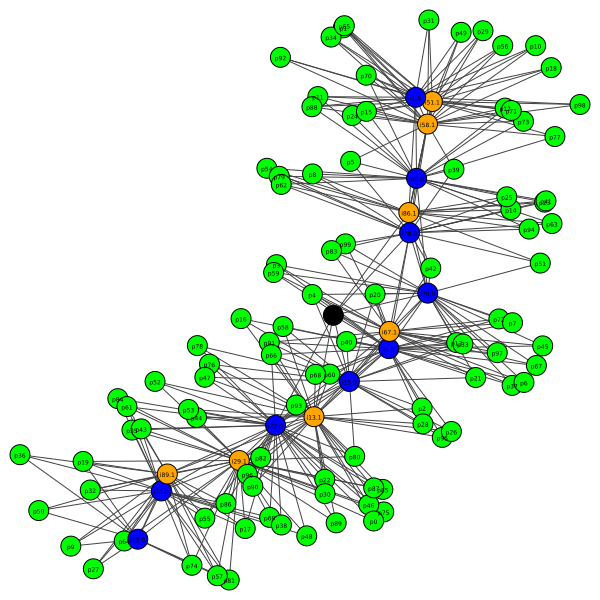

In [9]:
model.optimize()

installation_pairs, installation = get_installation(X)
kcmc_instance.plot(labels=True, installation=installation, minimal=True)

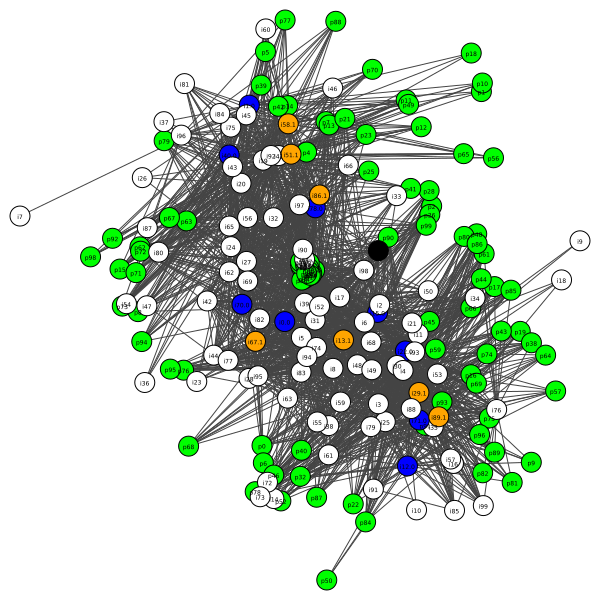

In [10]:
kcmc_instance.plot(labels=True, installation=installation, minimal=False)